In [ ]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

# Model
from xgboost import XGBClassifier

# Explainability
import shap

In [ ]:
# Mount Google Drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Credit Card Fraud Detection/dataset/fraudTrain.csv')

In [ ]:
cols_to_drop = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num',
                'first', 'last', 'gender', 'street', 'city', 'state',
                'zip', 'dob', 'trans_num']
df.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
le = LabelEncoder()

df['merchant'] = le.fit_transform(df['merchant'])
df['category'] = le.fit_transform(df['category'])
df['job'] = le.fit_transform(df['job'])

In [ ]:
le = LabelEncoder()
df['merchant'] = le.fit_transform(df['merchant'])
df['category'] = le.fit_transform(df['category'])
df['job'] = le.fit_transform(df['job'])

In [ ]:
scaler = StandardScaler()
num_cols = ['amt', 'city_pop', 'unix_time', 'lat', 'long', 'merch_lat', 'merch_long']
df[num_cols] = scaler.fit_transform(df[num_cols])

In [ ]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Handle imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
xgb = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42,
                    n_jobs=-1, eval_metric='logloss')
xgb.fit(X_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=-1, num_parallel_tree=None, random_state=42, ...)

In [ ]:
# Predictions
y_probs = xgb.predict_proba(X_test)[:, 1]
threshold = 0.9  # Selected threshold
y_pred_thresh = (y_probs >= threshold).astype(int)

In [ ]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred_thresh))
print("Classification Report:\n", classification_report(y_test, y_pred_thresh))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_thresh))

Accuracy: 0.9939229182331734
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    257834
           1       0.48      0.77      0.59      1501

    accuracy                           0.99    259335
   macro avg       0.74      0.88      0.80    259335
weighted avg       1.00      0.99      0.99    259335

Confusion Matrix:
 [[256605   1229]
 [   347   1154]]


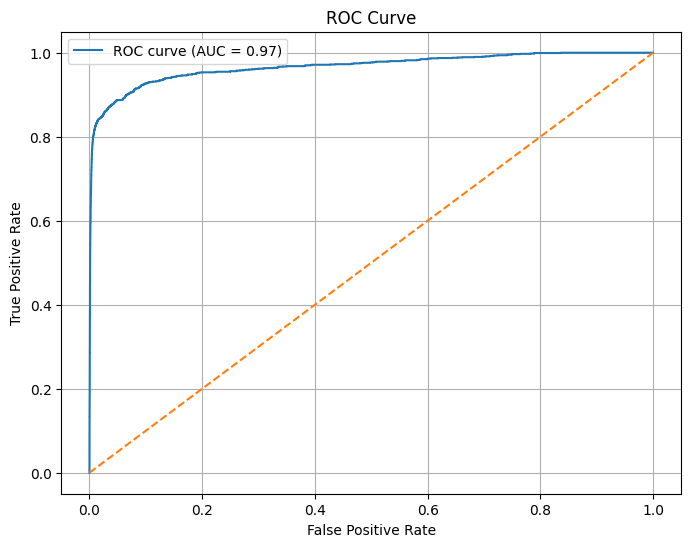

In [ ]:
# ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

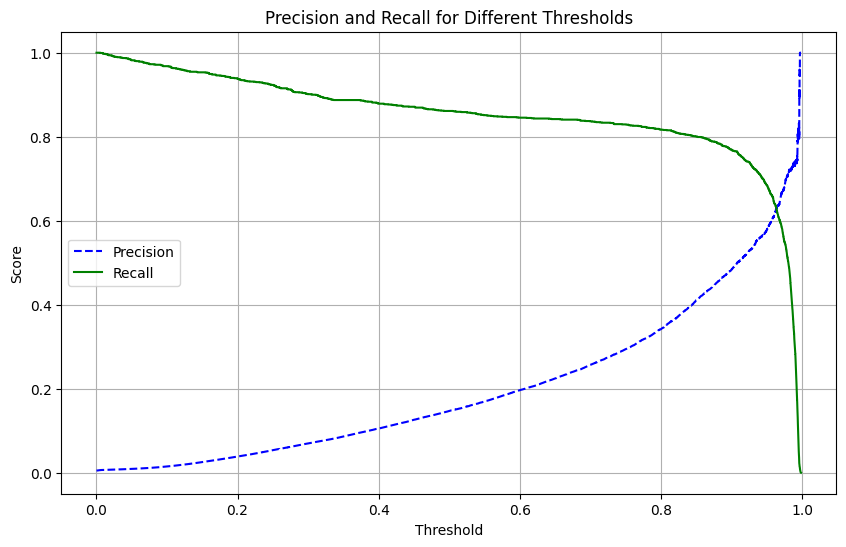

In [ ]:
# Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
plt.figure(figsize=(10, 6))
plt.plot(pr_thresholds, precision[:-1], "b--", label="Precision")
plt.plot(pr_thresholds, recall[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.title("Precision and Recall for Different Thresholds")
plt.show()

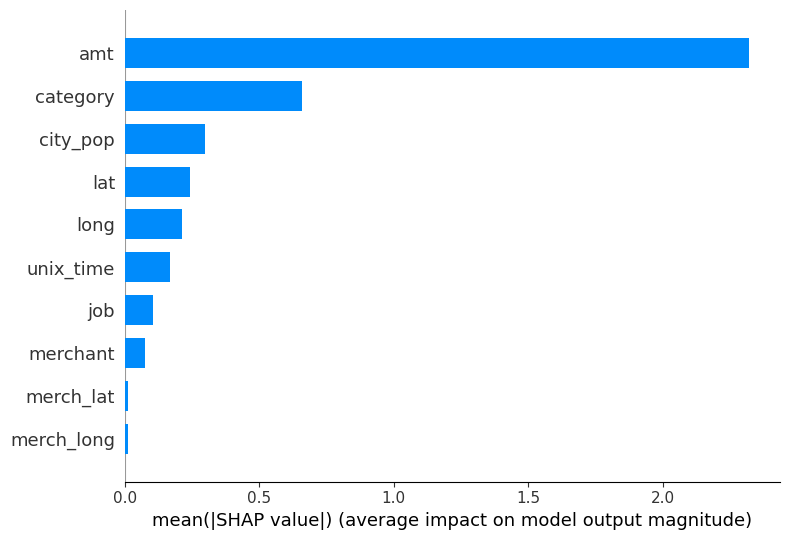

In [ ]:
# SHAP Explainability
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# CROSS-VALIDATION
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb, X_train_resampled, y_train_resampled, cv=5, scoring='f1')
print("Cross-validation F1 scores:", cv_scores)
print("Mean F1 score:", cv_scores.mean())

Cross-validation F1 scores: [0.93310563 0.93458896 0.93509192 0.9362406  0.93427243]
Mean F1 score: 0.9346599097098467


In [ ]:
# SAVE MODEL
import joblib
model_filename = 'xgboost_fraud_model.joblib'
joblib.dump(xgb, model_filename)
print(f"Model saved as {model_filename}")

Model saved as xgboost_fraud_model.joblib


In [ ]:
# LOAD MODEL AND PREDICT
loaded_model = joblib.load(model_filename)
loaded_probs = loaded_model.predict_proba(X_test)[:, 1]
loaded_preds = (loaded_probs >= 0.9).astype(int)

In [ ]:
print("Accuracy (Loaded Model):", accuracy_score(y_test, loaded_preds))

Accuracy (Loaded Model): 0.9939229182331734


In [ ]:
# SHAP EXPLAINABILITY
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

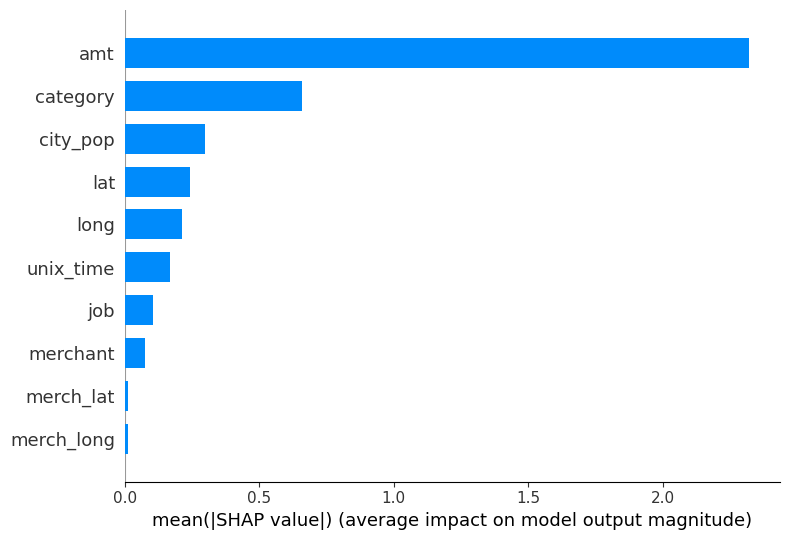

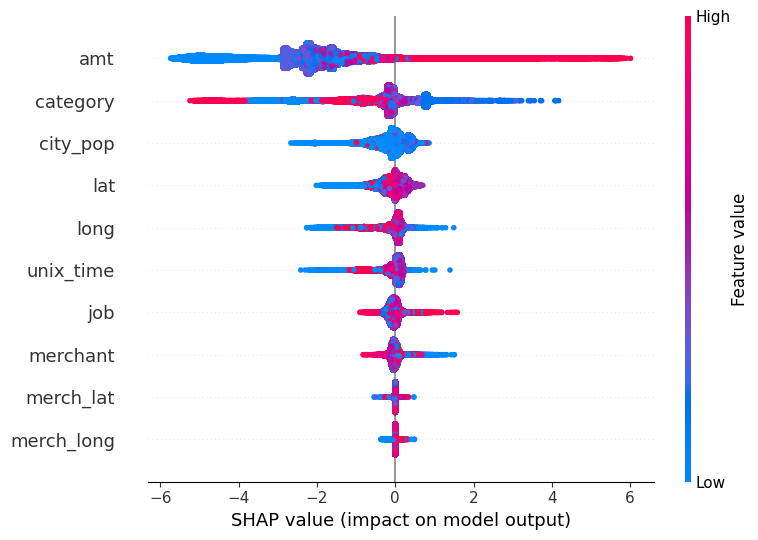

In [ ]:
# SHAP Summary plots
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test)

In [ ]:
# SHAP Force plot (optional interactive plot)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

In [ ]:
# XGBOOST FEATURE IMPORTANCE
importances = xgb.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

In [ ]:
print(feature_importance_df)

      Feature  Importance
2         amt    0.705058
1    category    0.127154
3         lat    0.036412
5    city_pop    0.032930
4        long    0.030765
7   unix_time    0.020421
6         job    0.019261
0    merchant    0.014430
9  merch_long    0.007128
8   merch_lat    0.006442


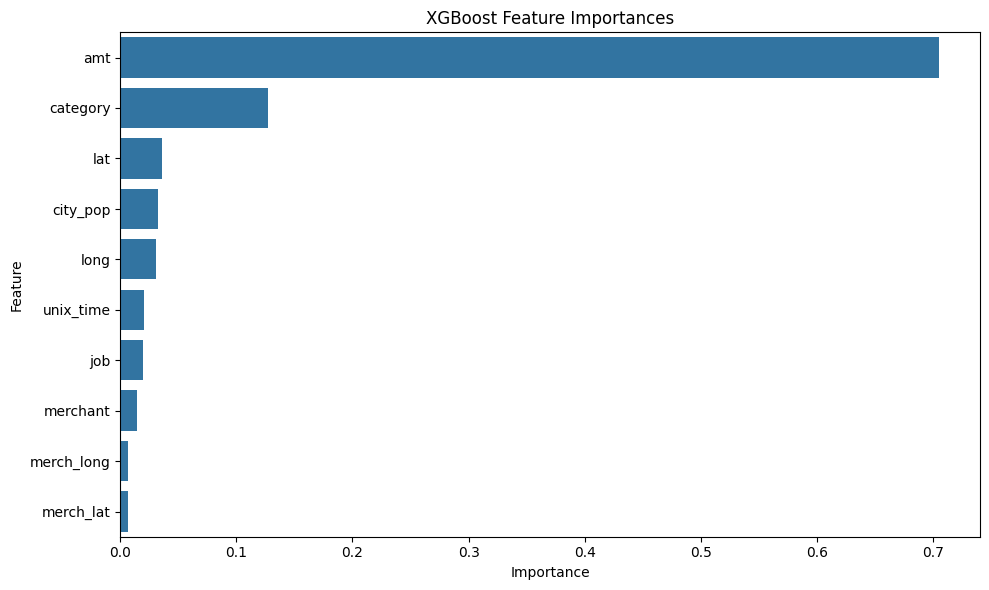

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()